In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [105]:
#Load dataset
data=pd.read_csv('IMDB_Dataset.csv')

In [106]:
#Inspect the data
print(data.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [107]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


In [108]:
print(data.describe())

                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000


Preprocess the data

In [109]:
import re
import string
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [110]:
#Basic text cleaning
def clean_text(text):
    text=text.lower()
    text=re.sub(f"[{string.punctuation}]", "", text) #Remove punctuation
    text=re.sub(r'\d+', '', text) #Remove numbers
    return text

data['review']=data['review'].apply(clean_text)

In [111]:
#Convert labels from strings to float
data['sentiment']=data['sentiment'].map({'positive':1, 'negative':0})

print(data['sentiment'].unique())

[1 0]


In [112]:
print(data['sentiment'].value_counts())

sentiment
1    25000
0    25000
Name: count, dtype: int64


In [113]:
#Split data
X = data['review']
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [114]:
#Tokenization and padding
tokenizer=Tokenizer(num_words=5000) #Use top 5000 words
tokenizer.fit_on_texts(X_train)

X_train_seq=tokenizer.texts_to_sequences(X_train)
X_test_seq=tokenizer.texts_to_sequences(X_test)

In [115]:
max_len=100 #Limit reviews to 100 words

X_train_padded=pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_padded=pad_sequences(X_test_seq, maxlen=max_len, padding='post')

Build Sentiment Analysis Model

In [116]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization

In [117]:
model=Sequential()

# Input layer with embedding
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_len))

# LSTM layer
model.add(LSTM(64, return_sequences=True))

model.add(Dropout(0.5))

# LSTM layer2
model.add(LSTM(128, return_sequences=False))

model.add(Dropout(0.5))

# Hidden layer 1
model.add(Dense(units=64, kernel_initializer='he_uniform',  activation='relu'))

model.add(Dropout(0.5))

# Output layer
model.add(Dense(units=1, kernel_initializer='he_uniform', activation='sigmoid'))  # Sigmoid for binary classification

c:\Program Files\Python39\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [118]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [119]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

print(class_weights)

{0: 0.9980537950995558, 1: 1.0019538099293623}


In [120]:
#Train the model
history = model.fit(
    X_train_padded, y_train,
    validation_data=(X_test_padded, y_test),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 114s 89ms/step - accuracy: 0.7206 - loss: 0.5323 - val_accuracy: 0.8476 - val_loss: 0.3486
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 123s 99ms/step - accuracy: 0.8739 - loss: 0.3212 - val_accuracy: 0.8506 - val_loss: 0.3304
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 128s 102ms/step - accuracy: 0.8947 - loss: 0.2685 - val_accuracy: 0.8630 - val_loss: 0.3239
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 126s 100ms/step - accuracy: 0.9171 - loss: 0.2242 - val_accuracy: 0.8566 - val_loss: 0.3539
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 138s 111ms/step - accuracy: 0.9296 - loss: 0.1926 - val_accuracy: 0.8583 - val_loss: 0.3455
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 153s 123ms/step - accuracy: 0.9400 - loss: 0.1625 - val_accuracy: 0.8592 - val_loss: 0.4464
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 150s 120ms/step - accuracy: 0.9537 - loss: 0.1339 - val_accuracy: 0.8547 - val_loss: 0.4427
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 160s 128ms/step - accu

In [121]:
#Evaluate on test set
loss, accuracy=model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.8466 - loss: 0.5773
Test Accuracy: 0.85


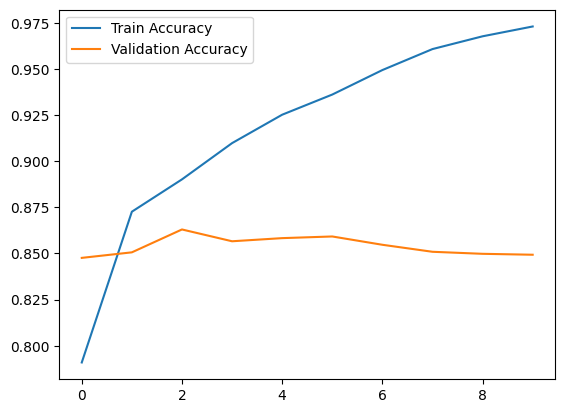

In [122]:
#Visualise training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [123]:
#Finding optimal threshold
from sklearn.metrics import roc_curve

y_pred_probs = model.predict(X_test_padded)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

#Find the threshold that maximizes the difference
optimal_idx = (tpr - fpr).argmax()
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step
Optimal Threshold: 0.4694187343120575


In [124]:
#Test the model
def classify_sentiment(text, threshold=optimal_threshold):
    text=clean_text(text)
    seq=tokenizer.texts_to_sequences([text])
    padded=pad_sequences(seq, maxlen=max_len, padding='post')
    prediction=model.predict(padded)[0][0]
    print(f"Prediction: {prediction}")
    return "Positive" if prediction > threshold else "Negative"

print(classify_sentiment("The movie was fantastic!"))
print(classify_sentiment("I did not like the film."))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Prediction: 0.7667971253395081
Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Prediction: 0.39363229274749756
Negative


In [125]:
#Save model
model.save('sentiment_analysis_model.h5')